In [ ]:
# Future imports
from __future__ import annotations

# Standard library imports
import csv
import glob
import concurrent.futures
import os
import sys
import warnings
from typing import Set

# Third-party imports
import ast
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import soundfile as sf
import tensorflow as tf
import torch
import whisper
from sklearn.ensemble import IsolationForest
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tqdm import tqdm
import re
import unicodedata

In [4]:
# count how many Q1, Q2, Q3, Q4 in the dataset

#read data from C:\Users\yingx\Downloads\MER_audio_taffc_dataset\panda_dataset_taffc_annotations.csv
data = pd.read_csv(r"C:/Users/yingx/Downloads/MER_audio_taffc_dataset/panda_dataset_taffc_annotations.csv")
label_counts = data['Quadrant'].value_counts()
print(label_counts)

Quadrant
Q3    225
Q2    225
Q1    225
Q4    225
Name: count, dtype: int64


In [7]:
# Create features.csv by extracting audio features from MP3 files
# === PATHS ===
base_dir = r"C:/Users/yingx\Downloads/MER_audio_taffc_dataset/"
question_dirs = [os.path.join(base_dir, f"Q{i}") for i in range(1, 5)]
output_csv = os.path.join(base_dir, "data", "features3.csv")


# === FEATURE EXTRACTION ===
def extract_features(audio_file):
    # Load MP3
    y, sr = librosa.load(audio_file, sr=None)

    # Calculate audio features
    duration = librosa.get_duration(y=y, sr=sr)
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y=y))
    chroma_feature = np.mean(librosa.feature.chroma_stft(y=y, sr=sr), axis=1)
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr), axis=1)
    rms = np.mean(librosa.feature.rms(y=y))
    harmonicity = np.mean(librosa.effects.harmonic(y))

    # Extract ID (e.g., MT0000011357 from "MT0000011357.mp3")
    base = os.path.basename(audio_file)
    file_id = os.path.splitext(base)[0]   # keep as string

    return {
        'id': file_id,
        'duration': duration,
        'tempo': tempo,
        'spectral_centroid': spectral_centroid,
        'zero_crossing_rate': zero_crossing_rate,
        'chroma_feature': chroma_feature.tolist(),
        'mfccs': mfccs.tolist(),
        'rms': rms,
        'harmonicity': harmonicity
    }


def safe_extract(audio_file):
    try:
        if os.path.exists(audio_file):
            print(f"Processing: {audio_file}")
            return extract_features(audio_file)
        else:
            print(f"File not found: {audio_file}")
            return None
    except Exception as e:
        print(f"Error processing {audio_file}: {e}")
        return None


if __name__ == "__main__":
    # Collect all .mp3 files in Q1, Q2, Q3, Q4
    audio_files = []
    for qdir in question_dirs:
        audio_files.extend(glob.glob(os.path.join(qdir, "*.mp3")))

    print(f"Found {len(audio_files)} MP3 files in Q1–Q4.")

    # Ensure output directory exists
    os.makedirs(os.path.dirname(output_csv), exist_ok=True)

    batch_size = 100
    header_written = os.path.exists(output_csv)

    # Process in batches
    for start in range(0, len(audio_files), batch_size):
        batch = audio_files[start:start + batch_size]

        with concurrent.futures.ThreadPoolExecutor() as executor:
            results = list(executor.map(safe_extract, batch))

        batch_clean = [r for r in results if r is not None]

        if batch_clean:
            df = pd.DataFrame(batch_clean)
            columns = [
                'id', 'duration', 'tempo', 'spectral_centroid',
                'zero_crossing_rate', 'chroma_feature', 'mfccs',
                'rms', 'harmonicity'
            ]
            df = df[columns]

            df.to_csv(
                output_csv,
                mode='a',
                header=not header_written,
                index=False
            )
            header_written = True

        print(f"Processed batch {start} → {start + len(batch) - 1}")

    print(f"\n🎉 Feature extraction complete.")
    print(f"Features saved to: {output_csv}")


Found 900 MP3 files in Q1–Q4.
Processing: C:\Users\yingx\Downloads\MER_audio_taffc_dataset\Q1\MT0000040632.mp3
Processing: C:\Users\yingx\Downloads\MER_audio_taffc_dataset\Q1\MT0000082187.mp3
Processing: C:\Users\yingx\Downloads\MER_audio_taffc_dataset\Q1\MT0000249842.mp3
Processing: C:\Users\yingx\Downloads\MER_audio_taffc_dataset\Q1\MT0000364027.mp3
Processing: C:\Users\yingx\Downloads\MER_audio_taffc_dataset\Q1\MT0000392975.mp3
Processing: C:\Users\yingx\Downloads\MER_audio_taffc_dataset\Q1\MT0000414517.mp3
Processing: C:\Users\yingx\Downloads\MER_audio_taffc_dataset\Q1\MT0000442827.mp3
Processing: C:\Users\yingx\Downloads\MER_audio_taffc_dataset\Q1\MT0000540286.mp3
Processing: C:\Users\yingx\Downloads\MER_audio_taffc_dataset\Q1\MT0000664362.mp3
Processing: C:\Users\yingx\Downloads\MER_audio_taffc_dataset\Q1\MT0000992846.mp3
Processing: C:\Users\yingx\Downloads\MER_audio_taffc_dataset\Q1\MT0001053268.mp3
Processing: C:\Users\yingx\Downloads\MER_audio_taffc_dataset\Q1\MT0001189913.mp

In [12]:
# Read the input CSV file
df = pd.read_csv("C:/Users/yingx/Downloads/MER_audio_taffc_dataset/panda_dataset_taffc_annotations.csv")
output_csv = r"C:/Users/yingx/Downloads/MER_audio_taffc_dataset/data/emotion3.csv"

# Define a function to determine emotion, if in 'Quadrant' column is labeled Q1, it is 'Happy', Q2 is 'Anger', Q3 is 'Sad', Q4 is 'Relaxed'
def determine_emotion(quadrant):
    if quadrant == 'Q1':
        return 'Happy'
    elif quadrant == 'Q2':
        return 'Anger'
    elif quadrant == 'Q3':
        return 'Sad'
    elif quadrant == 'Q4':
        return 'Relaxed'
    else:
        return 'Unknown'

# Create a csv emotion3.csv with columns 'id' and 'emotion'. id will be from df['Song'] and emotion will be determined by the function above
emotion_df = pd.DataFrame()
emotion_df['id'] = df['Song']
emotion_df['emotion'] = df['Quadrant'].apply(determine_emotion)
emotion_df.to_csv(output_csv, index=False)
print(f"Emotion labels saved to: {output_csv}")

Emotion labels saved to: C:/Users/yingx/Downloads/MER_audio_taffc_dataset/data/emotion3.csv


In [16]:
# Load model Whisper model
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

print(f"Loading Whisper model 'base' on {device}...")
model = whisper.load_model("base", device=device)
print("Model loaded.")

Using device: cpu
Loading Whisper model 'base' on cpu...
Model loaded.


In [17]:
# Transcribe audio files and save to CSV

# === PATHS ===
base_dir = r"C:/Users/yingx/Downloads/MER_audio_taffc_dataset/"
question_dirs = [os.path.join(base_dir, f"Q{i}") for i in range(1, 5)]
OUTPUT_CSV = os.path.join(base_dir, "data", "transcription3.csv")

# --------- Helpers ---------
def read_processed_ids(path: str) -> Set[str]:
    """
    Read the first column (id) from an existing CSV and return a set of ids (strings).
    """
    if not os.path.exists(path):
        return set()
    ids: Set[str] = set()
    try:
        with open(path, newline="", encoding="utf-8") as f:
            reader = csv.reader(f)
            header = next(reader, None)  # skip header if present
            for row in reader:
                if not row:
                    continue
                file_id = row[0].strip()
                if file_id:
                    ids.add(file_id)
    except Exception:
        return set()
    return ids

# Make sure output directory exists
outdir = os.path.dirname(OUTPUT_CSV)
if outdir and not os.path.exists(outdir):
    os.makedirs(outdir, exist_ok=True)

# Read already processed ids so we can skip them
processed = read_processed_ids(OUTPUT_CSV)
if processed:
    print(f"Found {len(processed)} already-processed ids in {OUTPUT_CSV}; these will be skipped.")

write_header = not os.path.exists(OUTPUT_CSV)

# Allow only basic English letters, digits, spaces, and common punctuation
ALLOWED_CHARS = re.compile(r"[^a-zA-Z0-9\s.,!?;:'\"-]")

def clean_transcription_text(raw_text: str) -> str:
    # Normalize Unicode
    text = unicodedata.normalize("NFKC", raw_text or "")
    # Keep only allowed chars
    text = ALLOWED_CHARS.sub("", text)
    # Collapse extra whitespace
    text = re.sub(r"\s+", " ", text).strip()
    return text

# --------- Collect all MP3 files from Q1–Q4 ---------
audio_files = []
for qdir in question_dirs:
    audio_files.extend(glob.glob(os.path.join(qdir, "*.mp3")))

print(f"Found {len(audio_files)} MP3 files in Q1–Q4.")

count = 0
with open(OUTPUT_CSV, "a", newline="", encoding="utf-8") as csvfile:
    writer = csv.writer(csvfile)
    if write_header:
        writer.writerow(["id", "transcription"])

    for audio_path in audio_files:
        # ID is the filename without extension, e.g. "MT0000004637"
        base = os.path.basename(audio_path)
        file_id = os.path.splitext(base)[0]

        if file_id in processed:
            continue

        try:
            # Force English and disable fp16
            result = model.transcribe(audio_path, language="en", fp16=False)
            raw_text = result.get("text", "") or ""
            text = clean_transcription_text(raw_text)
        except Exception as e:
            print(f"Error transcribing {audio_path}: {e}")
            text = ""

        writer.writerow([file_id, text])
        count += 1

        # Flush to disk
        try:
            csvfile.flush()
            os.fsync(csvfile.fileno())
        except Exception:
            pass

        if count % 100 == 0:
            print(f"Processed {count} new files so far...")

print(f"Done. Transcriptions written (appended) to: {OUTPUT_CSV}")


Found 900 MP3 files in Q1–Q4.
Processed 100 new files so far...
Processed 200 new files so far...
Processed 300 new files so far...
Processed 400 new files so far...
Processed 500 new files so far...
Processed 600 new files so far...
Processed 700 new files so far...
Processed 800 new files so far...
Processed 900 new files so far...
Done. Transcriptions written (appended) to: C:/Users/yingx/Downloads/MER_audio_taffc_dataset/data\transcription3.csv


In [19]:
# Merge features3.csv, transcription3.csv, and emotion3.csv into a singular CSV file

# === PATHS ===
base_dir = r"C:/Users/yingx/Downloads/MER_audio_taffc_dataset/"
OUTPUT_CSV = os.path.join(base_dir, "data", "merged3.csv")

# Read input CSV files
features_df = pd.read_csv(os.path.join(base_dir, "data", "features3.csv"))
transcription_df = pd.read_csv(os.path.join(base_dir, "data", "transcription3.csv"))
emotion_df = pd.read_csv(os.path.join(base_dir, "data", "emotion3.csv"))

# Merge DataFrames on 'id'
merged_df = features_df.merge(transcription_df, on='id').merge(emotion_df, on='id')

# Save merged DataFrame to CSV
merged_df.to_csv(OUTPUT_CSV, index=False)
print(f"Merged data saved to: {OUTPUT_CSV}")

Merged data saved to: C:/Users/yingx/Downloads/MER_audio_taffc_dataset/data\merged3.csv


In [20]:
# Train / Test split

data = pd.read_csv(r"C:/Users/yingx/Downloads/MER_audio_taffc_dataset/data/merged3.csv")
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, stratify=data['emotion'])

# Get X_test, y_test, X_train, y_train
X_train = train_data.drop(columns=['id', 'emotion'])
y_train = train_data['emotion']
X_test = test_data.drop(columns=['id', 'emotion'])
y_test = test_data['emotion']

# Print shapes
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Print columns
print(f"Feature columns: {X_train.columns.tolist()}")

X_train shape: (720, 9)
y_train shape: (720,)
X_test shape: (180, 9)
y_test shape: (180,)
Feature columns: ['duration', 'tempo', 'spectral_centroid', 'zero_crossing_rate', 'chroma_feature', 'mfccs', 'rms', 'harmonicity', 'transcription']


In [21]:
def create_dataset(features_dict, batch_size=32, shuffle=True):
    """
    Create a tf.data.Dataset from processed_features.

    It will automatically:
    - Combine numerical features into a (N, num_numeric, 1) tensor named 'numerical_input'
    - Use 'chroma' -> 'chroma_input' with shape (N, 12, 1) if present
    - Use 'mfcc'   -> 'mfcc_input' with shape (N, 20, 1) if present
    - Use 'text_input' as-is if present
    - Use 'labels' as targets
    """

    inputs = {}
    
    # 1) Numerical features (duration, tempo, etc.) -> numerical_input
    numeric_cols = ['duration', 'tempo', 'spectral_centroid',
                    'zero_crossing_rate', 'rms', 'harmonicity']
    available_numeric = [c for c in numeric_cols if c in features_dict]

    if available_numeric:
        # Each processed_features[feature] is shape (N,)
        numeric_arrays = [features_dict[c] for c in available_numeric]
        numeric_stack = np.stack(numeric_arrays, axis=1)  # (N, num_numeric)
        numeric_stack = np.expand_dims(numeric_stack, -1)  # (N, num_numeric, 1)
        inputs['numerical_input'] = numeric_stack

    # 2) Chroma features -> chroma_input (N, 12, 1)
    if 'chroma' in features_dict:
        chroma = features_dict['chroma']  # (N, 12)
        chroma = np.expand_dims(chroma, -1)  # (N, 12, 1)
        inputs['chroma_input'] = chroma

    # 3) MFCC features -> mfcc_input (N, 20, 1)
    if 'mfcc' in features_dict:
        mfcc = features_dict['mfcc']  # (N, 20)
        mfcc = np.expand_dims(mfcc, -1)  # (N, 20, 1)
        inputs['mfcc_input'] = mfcc

    # 4) Text / lyrics -> text_input (already (N, max_len))
    if 'text_input' in features_dict:
        inputs['text_input'] = features_dict['text_input']

    # 5) Labels
    labels = features_dict['labels']

    # Build tf.data.Dataset
    ds = tf.data.Dataset.from_tensor_slices((inputs, labels))

    if shuffle:
        ds = ds.shuffle(buffer_size=len(labels), reshuffle_each_iteration=True)

    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds


In [22]:
# Preprocessing and dataset creation for CNN-Transformer model
def safe_normalize(values, mean, std):
    """Safe normalization with epsilon protection to prevent NaN/Inf"""
    epsilon = 1e-8
    safe_std = np.maximum(std, epsilon)
    values = np.clip(values, -1e6, 1e6)
    normalized = (values - mean) / safe_std
    normalized = np.nan_to_num(normalized, nan=0.0, posinf=1e6, neginf=-1e6)
    return normalized

def preprocess_features(
    X,
    y=None,
    label_encoder=None,
    tokenizer=None,
    max_text_len=None,
    is_training=True,
    training_stats=None
):
    """
    Preprocess features for CNN-Transformer model.
    Uses training statistics for test normalization if is_training=False.
    """
    processed_features = {}

    # If test data, bring in training stats (means/stds)
    if not is_training and training_stats is not None:
        processed_features.update(training_stats)

    # 1. Numerical features
    numerical_features = [
        'duration',
        'tempo',
        'spectral_centroid',
        'zero_crossing_rate',
        'rms',
        'harmonicity'
    ]
    for feature in numerical_features:
        if feature in X.columns:
            values = X[feature].values.astype(np.float32)

            if is_training:
                processed_features[f'{feature}_mean'] = np.mean(values)
                processed_features[f'{feature}_std'] = np.std(values)

            values = safe_normalize(
                values,
                processed_features.get(f'{feature}_mean', 0),
                processed_features.get(f'{feature}_std', 1)
            )
            processed_features[feature] = values

    # 2. Chroma features
    if 'chroma_feature' in X.columns:
        chroma_features = []
        for chroma_str in X['chroma_feature']:
            if pd.notna(chroma_str) and isinstance(chroma_str, str) and chroma_str.strip():
                try:
                    if chroma_str.startswith('[') and chroma_str.endswith(']'):
                        chroma_array = np.array(ast.literal_eval(chroma_str), dtype=np.float32)
                    else:
                        chroma_str_clean = chroma_str.replace('[', '').replace(']', '').strip()
                        if ',' in chroma_str_clean:
                            chroma_list = [
                                float(x.strip())
                                for x in chroma_str_clean.split(',')
                                if x.strip()
                            ]
                        else:
                            chroma_list = [
                                float(x.strip())
                                for x in chroma_str_clean.split()
                                if x.strip()
                            ]
                        chroma_array = np.array(chroma_list, dtype=np.float32)

                    if len(chroma_array) != 12:
                        if len(chroma_array) < 12:
                            padded = np.zeros(12, dtype=np.float32)
                            padded[:len(chroma_array)] = chroma_array
                            chroma_array = padded
                        else:
                            chroma_array = chroma_array[:12]
                except Exception:
                    chroma_array = np.zeros(12, dtype=np.float32)
            else:
                chroma_array = np.zeros(12, dtype=np.float32)

            chroma_features.append(chroma_array)

        chroma_features = np.array(chroma_features)

        if is_training:
            processed_features['chroma_mean'] = np.mean(chroma_features, axis=0)
            processed_features['chroma_std'] = np.std(chroma_features, axis=0)

        chroma_features = safe_normalize(
            chroma_features,
            processed_features.get('chroma_mean', 0),
            processed_features.get('chroma_std', 1)
        )
        processed_features['chroma'] = chroma_features

    # 3. MFCC features
    if 'mfccs' in X.columns:
        mfcc_features = []
        for mfcc_str in X['mfccs']:
            if pd.notna(mfcc_str) and isinstance(mfcc_str, str) and mfcc_str.strip():
                try:
                    if mfcc_str.startswith('[') and mfcc_str.endswith(']'):
                        mfcc_array = np.array(ast.literal_eval(mfcc_str), dtype=np.float32)
                    else:
                        mfcc_str_clean = mfcc_str.replace('[', '').replace(']', '').strip()
                        if ',' in mfcc_str_clean:
                            mfcc_list = [
                                float(x.strip())
                                for x in mfcc_str_clean.split(',')
                                if x.strip()
                            ]
                        else:
                            mfcc_list = [
                                float(x.strip())
                                for x in mfcc_str_clean.split()
                                if x.strip()
                            ]
                        mfcc_array = np.array(mfcc_list, dtype=np.float32)

                    if len(mfcc_array) != 20:
                        if len(mfcc_array) < 20:
                            padded = np.zeros(20, dtype=np.float32)
                            padded[:len(mfcc_array)] = mfcc_array
                            mfcc_array = padded
                        else:
                            mfcc_array = mfcc_array[:20]
                except Exception:
                    mfcc_array = np.zeros(20, dtype=np.float32)
            else:
                mfcc_array = np.zeros(20, dtype=np.float32)

            mfcc_features.append(mfcc_array)

        mfcc_features = np.array(mfcc_features)

        if is_training:
            processed_features['mfcc_mean'] = np.mean(mfcc_features, axis=0)
            processed_features['mfcc_std'] = np.std(mfcc_features, axis=0)

        mfcc_features = safe_normalize(
            mfcc_features,
            processed_features.get('mfcc_mean', 0),
            processed_features.get('mfcc_std', 1)
        )
        processed_features['mfcc'] = mfcc_features

    # 4. Text / transcription features
    if 'transcription' in X.columns:
        texts = X['transcription'].fillna('').astype(str).tolist()
        if is_training:
            tokenizer = Tokenizer(num_words=None, oov_token="<OOV>")
            tokenizer.fit_on_texts(texts)
            sequences = tokenizer.texts_to_sequences(texts)
            max_text_len = max(len(seq) for seq in sequences) or 1
            padded = pad_sequences(
                sequences,
                maxlen=max_text_len,
                padding='post',
                truncating='post'
            )
            processed_features['text_input'] = padded.astype('int32')
            processed_features['tokenizer'] = tokenizer
            processed_features['max_text_len'] = max_text_len
        else:
            sequences = tokenizer.texts_to_sequences(texts)
            padded = pad_sequences(
                sequences,
                maxlen=max_text_len,
                padding='post',
                truncating='post'
            )
            processed_features['text_input'] = padded.astype('int32')

    # 5. Labels
    if y is not None:
        if is_training:
            label_encoder = LabelEncoder()
            y_encoded = label_encoder.fit_transform(y)
            processed_features['label_encoder'] = label_encoder
        else:
            y_encoded = label_encoder.transform(y)

        processed_features['labels'] = y_encoded
        processed_features['num_classes'] = len(label_encoder.classes_)

    return processed_features

def prepare_cnn_transformer_data(X_train, X_test, y_train, y_test, batch_size=32):
    """
    Complete data preparation for CNN-Transformer model
    using a single train/test split.
    """
    print("Starting data preprocessing...")

    # 1) Preprocess training data
    train_features = preprocess_features(X_train, y_train, is_training=True)

    # Extract training statistics (means/stds) to reuse for test normalization
    training_stats = {
        key: value
        for key, value in train_features.items()
        if key.endswith('_mean') or key.endswith('_std')
    }

    # 2) Preprocess test data with training stats + same encoders/tokenizer
    test_features = preprocess_features(
        X_test,
        y_test,
        label_encoder=train_features['label_encoder'],
        tokenizer=train_features.get('tokenizer'),
        max_text_len=train_features.get('max_text_len'),
        is_training=False,
        training_stats=training_stats
    )

    # 3) Build tf.data.Dataset objects
    train_dataset = create_dataset(train_features, batch_size=batch_size, shuffle=True)
    test_dataset = create_dataset(test_features, batch_size=batch_size, shuffle=False)

    # 4) Infer input dimensions from one batch
    sample_inputs, _ = next(iter(train_dataset))
    input_dims = {}
    if 'numerical_input' in sample_inputs:
        input_dims['numerical'] = sample_inputs['numerical_input'].shape[-1]
    if 'chroma_input' in sample_inputs:
        input_dims['chroma'] = sample_inputs['chroma_input'].shape[-1]
    if 'mfcc_input' in sample_inputs:
        input_dims['mfcc'] = sample_inputs['mfcc_input'].shape[-1]
    if 'text_input' in sample_inputs:
        input_dims['text'] = sample_inputs['text_input'].shape[-1]

    print("Data preprocessing completed!")
    print(f"Number of classes: {train_features['num_classes']}")

    # Class distribution
    labels = train_features['labels']
    class_names = train_features['label_encoder'].classes_
    counts = np.bincount(labels)

    print("\nProcessed class counts:")
    for class_name, count in zip(class_names, counts):
        print(f"{class_name}: {count}")

    preprocessing_objects = {
        'label_encoder': train_features['label_encoder'],
        'tokenizer': train_features.get('tokenizer'),
        'max_text_len': train_features.get('max_text_len'),
        'normalization_params': training_stats
    }

    return train_dataset, test_dataset, input_dims, preprocessing_objects


# Updated usage
train_dataset, test_dataset, input_dims, preprocessing_objects = prepare_cnn_transformer_data(
    X_train, X_test, y_train, y_test
)

print("\nInput dimensions:", input_dims)


print("\nDataset Information:")
print(f"Training batches: {len(list(train_dataset))}")
print(f"Test batches: {len(list(test_dataset))}")
print(f"Input dimensions: {input_dims}")


# Verify batch shapes
for batch_inputs, batch_labels in train_dataset.take(1):
    print(f"\nBatch inputs keys: {batch_inputs.keys()}")
    for key, value in batch_inputs.items():
        print(f"{key} shape: {value.shape}")
    print(f"Batch labels shape: {batch_labels.shape}")
    break

Starting data preprocessing...
Data preprocessing completed!
Number of classes: 4

Processed class counts:
Anger: 180
Happy: 180
Relaxed: 180
Sad: 180

Input dimensions: {'numerical': 1, 'chroma': 1, 'mfcc': 1, 'text': 143}

Dataset Information:
Training batches: 23
Test batches: 6
Input dimensions: {'numerical': 1, 'chroma': 1, 'mfcc': 1, 'text': 143}

Batch inputs keys: dict_keys(['numerical_input', 'chroma_input', 'mfcc_input', 'text_input'])
numerical_input shape: (32, 6, 1)
chroma_input shape: (32, 12, 1)
mfcc_input shape: (32, 20, 1)
text_input shape: (32, 143)
Batch labels shape: (32,)


In [23]:
# After preprocessing, check data quality
def check_data_quality(features_dict, name="Data"):
    """Check for NaN/Inf values in processed features"""
    print(f"\n=== {name} Quality Check ===")
    for key, value in features_dict.items():
        if hasattr(value, 'dtype') and np.issubdtype(value.dtype, np.number):
            nan_count = np.sum(np.isnan(value))
            inf_count = np.sum(np.isinf(value))
            if nan_count > 0 or inf_count > 0:
                print(f"⚠️  WARNING: {key} has {nan_count} NaN, {inf_count} Inf values")
            else:
                print(f"✅ {key}: shape={value.shape}, range=[{np.min(value):.4f}, {np.max(value):.4f}]")

# Run the check
print("Preparing training data...")
train_features = preprocess_features(X_train, y_train, is_training=True)
check_data_quality(train_features, "Training Data")

test_features = preprocess_features(
    X_test,
    y_test,
    label_encoder=train_features['label_encoder'],
    tokenizer=train_features.get('tokenizer'),
    max_text_len=train_features.get('max_text_len'),
    is_training=False,
    training_stats={
        key: value
        for key, value in train_features.items()
        if key.endswith('_mean') or key.endswith('_std')
    }
)
check_data_quality(test_features, "Test Data")

Preparing training data...

=== Training Data Quality Check ===
✅ duration_mean: shape=(), range=[29.7806, 29.7806]
✅ duration_std: shape=(), range=[1.1471, 1.1471]
✅ duration: shape=(720,), range=[-17.1739, 0.3063]
✅ tempo_mean: shape=(), range=[121.4923, 121.4923]
✅ tempo_std: shape=(), range=[30.9637, 30.9637]
✅ tempo: shape=(720,), range=[-2.0271, 3.6628]
✅ spectral_centroid_mean: shape=(), range=[2053.8010, 2053.8010]
✅ spectral_centroid_std: shape=(), range=[713.0530, 713.0530]
✅ spectral_centroid: shape=(720,), range=[-2.3436, 2.7140]
✅ zero_crossing_rate_mean: shape=(), range=[0.0799, 0.0799]
✅ zero_crossing_rate_std: shape=(), range=[0.0355, 0.0355]
✅ zero_crossing_rate: shape=(720,), range=[-1.8458, 4.5366]
✅ rms_mean: shape=(), range=[0.1440, 0.1440]
✅ rms_std: shape=(), range=[0.0681, 0.0681]
✅ rms: shape=(720,), range=[-1.8751, 3.7638]
✅ harmonicity_mean: shape=(), range=[-0.0001, -0.0001]
✅ harmonicity_std: shape=(), range=[0.0037, 0.0037]
✅ harmonicity: shape=(720,), ran

In [24]:
def create_cnn_block(input_layer, filters, kernel_size, pool_size, dropout_rate=0.3, name_prefix=""):
    """Create a CNN block with convolution, batch norm, and dropout"""
    x = layers.Conv1D(filters, kernel_size, padding='same', activation='relu',
                      name=f'{name_prefix}_conv1')(input_layer)
    x = layers.BatchNormalization(name=f'{name_prefix}_bn1')(x)
    x = layers.MaxPooling1D(pool_size, name=f'{name_prefix}_pool1')(x)
    x = layers.Dropout(dropout_rate, name=f'{name_prefix}_dropout1')(x)

    x = layers.Conv1D(filters * 2, kernel_size, padding='same', activation='relu',
                      name=f'{name_prefix}_conv2')(x)
    x = layers.BatchNormalization(name=f'{name_prefix}_bn2')(x)
    x = layers.MaxPooling1D(pool_size, name=f'{name_prefix}_pool2')(x)
    x = layers.Dropout(dropout_rate, name=f'{name_prefix}_dropout2')(x)

    return x

In [30]:
def build_cnn_transformer_model(input_dims, num_classes, preprocessing_objects):
    """Build CNN + text model with gradient clipping support"""
    
    # --- Input shapes based on your dataset ---
    # numerical_input: (batch, 6, 1)
    # chroma_input:    (batch, 12, 1)
    # mfcc_input:      (batch, 20, 1)
    # text_input:      (batch, 143)
    
    numerical_input = layers.Input(shape=(6, 1), name='numerical_input')
    chroma_input    = layers.Input(shape=(12, 1), name='chroma_input')
    mfcc_input      = layers.Input(shape=(20, 1), name='mfcc_input')
    
    text_len   = input_dims.get('text', 143)  # from prepare_cnn_transformer_data
    text_input = layers.Input(shape=(text_len,), name='text_input', dtype='int32')
    
    # --- Numerical branch ---
    num_conv = layers.Conv1D(
        32, 2, activation='relu', kernel_initializer='he_normal'
    )(numerical_input)
    num_bn   = layers.BatchNormalization()(num_conv)
    num_pool = layers.GlobalAveragePooling1D()(num_bn)
    
    # --- Chroma branch ---
    chroma_conv = layers.Conv1D(
        32, 2, activation='relu', kernel_initializer='he_normal'
    )(chroma_input)
    chroma_bn   = layers.BatchNormalization()(chroma_conv)
    chroma_pool = layers.GlobalAveragePooling1D()(chroma_bn)
    
    # --- MFCC branch ---
    mfcc_conv = layers.Conv1D(
        32, 2, activation='relu', kernel_initializer='he_normal'
    )(mfcc_input)
    mfcc_bn   = layers.BatchNormalization()(mfcc_conv)
    mfcc_pool = layers.GlobalAveragePooling1D()(mfcc_bn)
    
    # --- Text / lyrics branch ---
    tokenizer   = preprocessing_objects.get('tokenizer')
    vocab_size  = len(tokenizer.word_index) + 1 if tokenizer is not None else 1
    
    text_embedding = layers.Embedding(
        input_dim=vocab_size,
        output_dim=64,
        mask_zero=True
    )(text_input)
    
    text_lstm    = layers.LSTM(64, return_sequences=False)(text_embedding)
    text_dropout = layers.Dropout(0.5)(text_lstm)
    
    # --- Concatenate all branches ---
    concatenated = layers.Concatenate()([
        num_pool,
        chroma_pool,
        mfcc_pool,
        text_dropout
    ])
    
    # --- Classifier head ---
    x = layers.Dense(128, activation='relu', kernel_initializer='he_normal')(concatenated)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Dense(64, activation='relu', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = Model(
        inputs=[numerical_input, chroma_input, mfcc_input, text_input],
        outputs=outputs
    )
    
    return model


# Build the model
num_classes = len(preprocessing_objects['label_encoder'].classes_)

print("Building CNN-Transformer model...")
model = build_cnn_transformer_model(input_dims, num_classes=num_classes,
                                    preprocessing_objects=preprocessing_objects)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, clipvalue=1.0),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Model built successfully!")
model.summary()

# Save untrained model to file (optional)
save_path = r"C:/Users/yingx/OneDrive/Documents/GitHub/Capstone/cnn_transformer_model.h5"
model.save(save_path)
print(f"Model saved to: {save_path}")

# Plot model architecture (optional)
try:
    tf.keras.utils.plot_model(
        model,
        to_file='cnn_transformer_model.png',
        show_shapes=True,
        show_layer_names=True,
        expand_nested=True
    )
    print("Model architecture saved as 'cnn_transformer_model.png'")
except Exception as e:
    print(f"Could not plot model architecture: {e}")

# Calculate class weights for imbalanced data (if any)
label_encoder = preprocessing_objects['label_encoder']
y_train_encoded = label_encoder.transform(y_train.to_numpy())

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_encoded),
    y=y_train_encoded
)

class_weight_dict = {
    int(cls): float(w) for cls, w in zip(np.unique(y_train_encoded), class_weights)
}

print(f"Class weights: {class_weight_dict}")

# Use callbacks but with reasonable patience
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-7,
        verbose=1
    )
]

print("Starting model training...")
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=test_dataset,
    class_weight=class_weight_dict,
    #callbacks=callbacks,
    verbose=1
)
print("Model training completed!")

Building CNN-Transformer model...
Model built successfully!
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 numerical_input (InputLayer)   [(None, 6, 1)]       0           []                               
                                                                                                  
 chroma_input (InputLayer)      [(None, 12, 1)]      0           []                               
                                                                                                  
 mfcc_input (InputLayer)        [(None, 20, 1)]      0           []                               
                                                                                                  
 text_input (InputLayer)        [(None, 143)]        0           []                               
                                

=== Overall Metrics ===
Accuracy      : 0.5167
F1 (macro)    : 0.4974
F1 (weighted) : 0.4974

=== Classification Report ===
              precision    recall  f1-score   support

       Anger       0.74      0.71      0.73        45
       Happy       0.41      0.51      0.46        45
     Relaxed       0.45      0.67      0.54        45
         Sad       0.57      0.18      0.27        45

    accuracy                           0.52       180
   macro avg       0.54      0.52      0.50       180
weighted avg       0.54      0.52      0.50       180


=== Confusion Matrix (raw) ===
[[32  9  4  0]
 [ 9 23 11  2]
 [ 1 10 30  4]
 [ 1 14 22  8]]


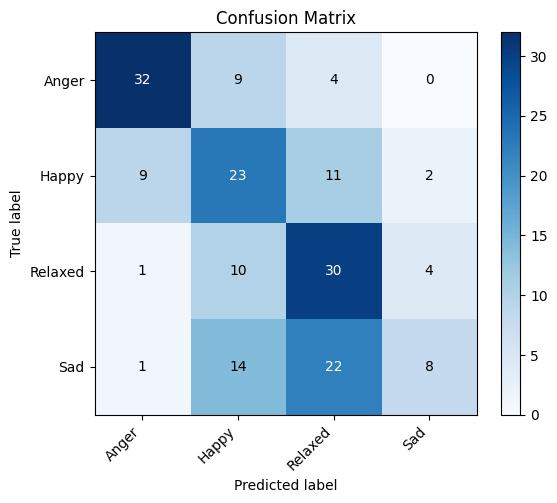

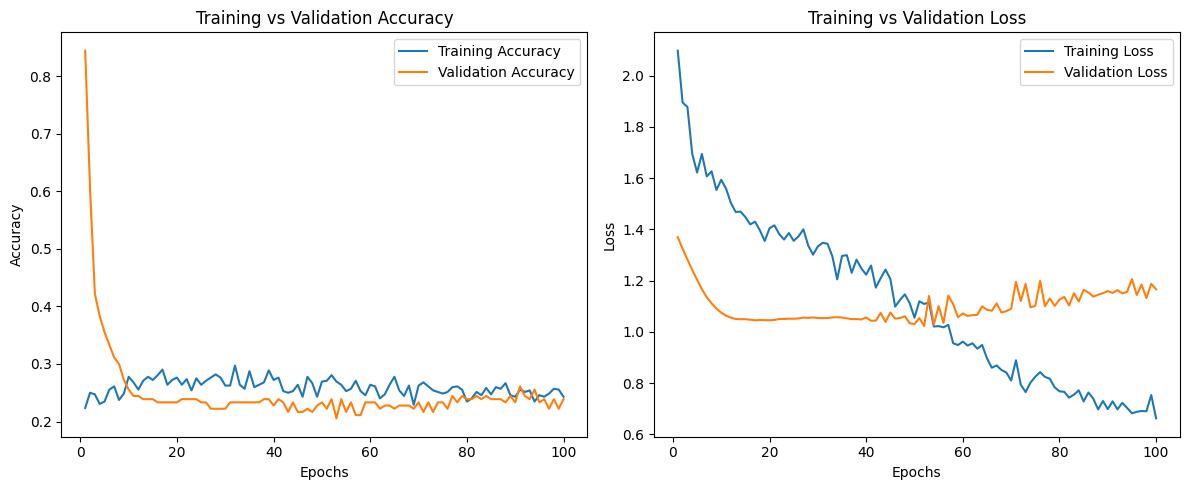

In [32]:
# ============================
# CNN Model Evaluation (Full)
# ============================

# 1. Collect true labels and predictions
y_true = []
y_pred = []

for batch_inputs, batch_labels in test_dataset:
    probs = model.predict(batch_inputs, verbose=0)
    preds = np.argmax(probs, axis=1)

    y_true.extend(batch_labels.numpy())
    y_pred.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# 2. Compute metrics
acc = accuracy_score(y_true, y_pred)
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_weighted = f1_score(y_true, y_pred, average='weighted')

print("=== Overall Metrics ===")
print(f"Accuracy      : {acc:.4f}")
print(f"F1 (macro)    : {f1_macro:.4f}")
print(f"F1 (weighted) : {f1_weighted:.4f}")

# 3. Classification Report
label_encoder = preprocessing_objects['label_encoder']
class_names = label_encoder.classes_

print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=class_names))

# 4. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("\n=== Confusion Matrix (raw) ===")
print(cm)

# 5. Pretty Confusion Matrix Plot
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.set_title("Confusion Matrix")
plt.colorbar(im, ax=ax)

tick_marks = np.arange(len(class_names))
ax.set_xticks(tick_marks)
ax.set_yticks(tick_marks)
ax.set_xticklabels(class_names, rotation=45, ha="right")
ax.set_yticklabels(class_names)

ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")

# Annotate numbers inside heatmap
threshold = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j, i, cm[i, j],
            ha="center", va="center",
            color="white" if cm[i, j] > threshold else "black"
        )

plt.tight_layout()
plt.show()

# 6. Plot training history (loss & accuracy)
def plot_training_history(history):
    """Plot training & validation accuracy and loss metrics"""
    acc = history.history.get('accuracy', [])
    val_acc = history.history.get('val_accuracy', [])
    loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)


In [33]:
# 0. Make copies of X so we don't mess up the original data
X_train_knn_base = X_train.copy()
X_test_knn_base  = X_test.copy()

# Drop text column so preprocess_features doesn't try to use tokenizer
for col in ['transcription']:
    if col in X_train_knn_base.columns:
        X_train_knn_base = X_train_knn_base.drop(columns=[col])
    if col in X_test_knn_base.columns:
        X_test_knn_base = X_test_knn_base.drop(columns=[col])

# 1. Preprocess training data for KNN (no text branch now)
knn_train_features = preprocess_features(
    X_train_knn_base,
    y_train,
    is_training=True
)

# Save normalization stats for test
knn_training_stats = {
    key: value
    for key, value in knn_train_features.items()
    if key.endswith('_mean') or key.endswith('_std')
}

# 2. Preprocess test data using training stats
knn_test_features = preprocess_features(
    X_test_knn_base,
    y_test,
    label_encoder=knn_train_features['label_encoder'],
    tokenizer=None,          # safe now; no transcription column
    max_text_len=None,
    is_training=False,
    training_stats=knn_training_stats
)

# Helper: flatten numerical + chroma + mfcc into one big matrix
def build_flat_feature_matrix(features_dict):
    num_cols = ['duration', 'tempo', 'spectral_centroid',
                'zero_crossing_rate', 'rms', 'harmonicity']
    
    numeric_stack = np.column_stack([features_dict[col] for col in num_cols])  # (N, 6)
    parts = [numeric_stack]

    if 'chroma' in features_dict:
        parts.append(features_dict['chroma'])   # (N, 12)
    if 'mfcc' in features_dict:
        parts.append(features_dict['mfcc'])     # (N, 20)

    flat_matrix = np.concatenate(parts, axis=1)  # (N, 6+12+20) = (N, 38)
    return flat_matrix

X_train_knn = build_flat_feature_matrix(knn_train_features)
X_test_knn  = build_flat_feature_matrix(knn_test_features)

y_train_knn = knn_train_features['labels']
y_test_knn  = knn_test_features['labels']

print("KNN feature shapes:")
print("X_train_knn:", X_train_knn.shape)
print("X_test_knn :", X_test_knn.shape)
print("y_train_knn:", y_train_knn.shape)
print("y_test_knn :", y_test_knn.shape)

KNN feature shapes:
X_train_knn: (720, 38)
X_test_knn : (180, 38)
y_train_knn: (720,)
y_test_knn : (180,)


In [36]:
from sklearn.neighbors import KNeighborsClassifier

# You can tweak n_neighbors later (3, 5, 7, etc.)
n = [3, 5, 7, 9]
for neighbors in n:
    knn = KNeighborsClassifier(
        n_neighbors=neighbors,
        weights='distance',    # closer neighbors have more influence
        metric='minkowski',    # Euclidean distance by default
    )

    knn.fit(X_train_knn, y_train_knn)
    train_acc = knn.score(X_train_knn, y_train_knn)
    test_acc  = knn.score(X_test_knn, y_test_knn)

    print(f"KNN with n_neighbors={neighbors}:")
    print(f"  Training Accuracy: {train_acc:.4f}")
    print(f"  Test Accuracy    : {test_acc:.4f}")

print("KNN training complete.")


KNN with n_neighbors=3:
  Training Accuracy: 1.0000
  Test Accuracy    : 0.5556
KNN with n_neighbors=5:
  Training Accuracy: 1.0000
  Test Accuracy    : 0.5167
KNN with n_neighbors=7:
  Training Accuracy: 1.0000
  Test Accuracy    : 0.5333
KNN with n_neighbors=9:
  Training Accuracy: 1.0000
  Test Accuracy    : 0.5333
KNN training complete.


=== KNN Overall Metrics ===
Accuracy      : 0.5333
F1 (macro)    : 0.5359
F1 (weighted) : 0.5359

=== KNN Classification Report ===
              precision    recall  f1-score   support

       Anger       0.72      0.64      0.68        45
       Happy       0.43      0.58      0.49        45
     Relaxed       0.54      0.44      0.49        45
         Sad       0.50      0.47      0.48        45

    accuracy                           0.53       180
   macro avg       0.55      0.53      0.54       180
weighted avg       0.55      0.53      0.54       180

=== KNN Confusion Matrix (raw) ===
[[29 12  2  2]
 [ 8 26  6  5]
 [ 1 10 20 14]
 [ 2 13  9 21]]


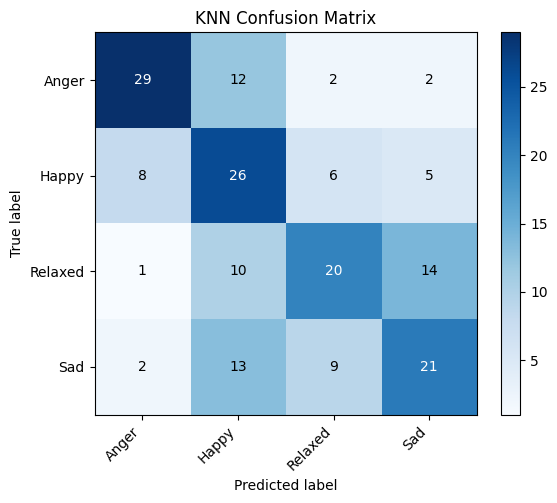

In [37]:
# Predict on test set
y_pred_knn = knn.predict(X_test_knn)

# Basic metrics
acc = accuracy_score(y_test_knn, y_pred_knn)
f1_macro = f1_score(y_test_knn, y_pred_knn, average='macro')
f1_weighted = f1_score(y_test_knn, y_pred_knn, average='weighted')

print("=== KNN Overall Metrics ===")
print(f"Accuracy      : {acc:.4f}")
print(f"F1 (macro)    : {f1_macro:.4f}")
print(f"F1 (weighted) : {f1_weighted:.4f}")

# Decode labels back to emotion names
label_encoder_knn = knn_train_features['label_encoder']
class_names = label_encoder_knn.classes_

print("\n=== KNN Classification Report ===")
print(classification_report(y_test_knn, y_pred_knn, target_names=class_names))

# Confusion matrix
cm_knn = confusion_matrix(y_test_knn, y_pred_knn)
print("=== KNN Confusion Matrix (raw) ===")
print(cm_knn)

# Pretty plot
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm_knn, interpolation='nearest', cmap=plt.cm.Blues)
ax.set_title("KNN Confusion Matrix")
plt.colorbar(im, ax=ax)

tick_marks = np.arange(len(class_names))
ax.set_xticks(tick_marks)
ax.set_yticks(tick_marks)
ax.set_xticklabels(class_names, rotation=45, ha="right")
ax.set_yticklabels(class_names)

ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")

threshold = cm_knn.max() / 2.0
for i in range(cm_knn.shape[0]):
    for j in range(cm_knn.shape[1]):
        ax.text(
            j, i, cm_knn[i, j],
            ha="center", va="center",
            color="white" if cm_knn[i, j] > threshold else "black"
        )

plt.tight_layout()
plt.show()


In [38]:
from sklearn.svm import SVC

# SVM with RBF kernel
svm_clf = SVC(
    kernel='rbf',          # radial basis function kernel
    C=10.0,                # regularization strength (you can tune)
    gamma='scale',         # default, usually good
    class_weight='balanced',  # in case of any slight imbalance
    probability=False,     # we just need class labels, not probabilities
    random_state=42
)

print("Training SVM...")
svm_clf.fit(X_train_knn, y_train_knn)
print("SVM training complete.")


Training SVM...
SVM training complete.


=== SVM Overall Metrics ===
Accuracy      : 0.5667
F1 (macro)    : 0.5672
F1 (weighted) : 0.5672

=== SVM Classification Report ===
              precision    recall  f1-score   support

       Anger       0.73      0.71      0.72        45
       Happy       0.49      0.49      0.49        45
     Relaxed       0.51      0.56      0.53        45
         Sad       0.55      0.51      0.53        45

    accuracy                           0.57       180
   macro avg       0.57      0.57      0.57       180
weighted avg       0.57      0.57      0.57       180

=== SVM Confusion Matrix (raw) ===
[[32  6  4  3]
 [10 22  6  7]
 [ 1 10 25  9]
 [ 1  7 14 23]]


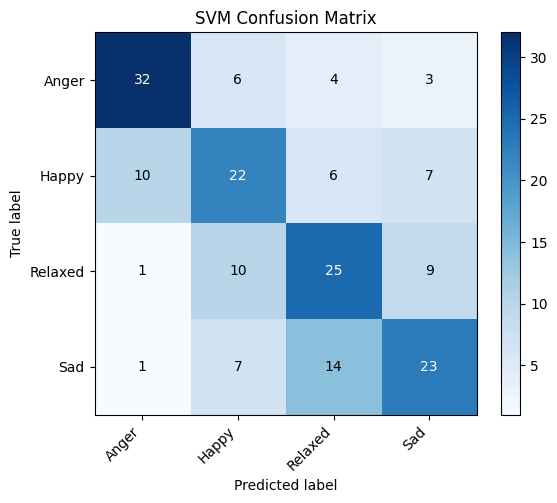

In [39]:
# Predict on test set
y_pred_svm = svm_clf.predict(X_test_knn)

# Overall metrics
acc_svm = accuracy_score(y_test_knn, y_pred_svm)
f1_macro_svm = f1_score(y_test_knn, y_pred_svm, average='macro')
f1_weighted_svm = f1_score(y_test_knn, y_pred_svm, average='weighted')

print("=== SVM Overall Metrics ===")
print(f"Accuracy      : {acc_svm:.4f}")
print(f"F1 (macro)    : {f1_macro_svm:.4f}")
print(f"F1 (weighted) : {f1_weighted_svm:.4f}")

# Class names (emotions)
class_names_svm = label_encoder_knn.classes_

print("\n=== SVM Classification Report ===")
print(classification_report(y_test_knn, y_pred_svm, target_names=class_names_svm))

# Confusion matrix
cm_svm = confusion_matrix(y_test_knn, y_pred_svm)
print("=== SVM Confusion Matrix (raw) ===")
print(cm_svm)

# Pretty confusion matrix plot
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm_svm, interpolation='nearest', cmap=plt.cm.Blues)
ax.set_title("SVM Confusion Matrix")
plt.colorbar(im, ax=ax)

tick_marks = np.arange(len(class_names_svm))
ax.set_xticks(tick_marks)
ax.set_yticks(tick_marks)
ax.set_xticklabels(class_names_svm, rotation=45, ha="right")
ax.set_yticklabels(class_names_svm)

ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")

threshold = cm_svm.max() / 2.0
for i in range(cm_svm.shape[0]):
    for j in range(cm_svm.shape[1]):
        ax.text(
            j, i, cm_svm[i, j],
            ha="center", va="center",
            color="white" if cm_svm[i, j] > threshold else "black"
        )

plt.tight_layout()
plt.show()
